# Preprocessing Data

In [1]:
# import the libraries
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
# make sure that on your systems you have the same tensorflow version installed + all the the libraries as well
print("Numpy Version: ",np.__version__)
print("Pillow Version: ", PIL.__version__)
print("TensorFlow Version: ",tf.__version__)
print("TensorFlow Dataset Version: ",tfds.__version__)

Numpy Version:  1.22.4
Pillow Version:  8.2.0
TensorFlow Version:  2.12.0
TensorFlow Dataset Version:  4.8.3


For **matplotlib**, I am running version 3.4.3  
Not sure, about **pathlib**, but if you need to install it, you can just do a pip install. 

In [3]:
# Now we will set the path:
# For this jupyter notebook, I am doing inside the repo folder, hopefully this works for you guys as well, let me know if it doesn't
data_path = pathlib.Path("../DATA").with_suffix('')
print(data_path)

..\DATA


In [4]:
# check to see how many images are in the folder
images_count = len(list(data_path.glob('*/*.jpeg')))
print(images_count)

3091


If you run this code and you get only 2000 images, it could be Github can only allow 1000 files for each folder. If this is the case, you can replace the data file from Github with the data file from Kaggle instead!

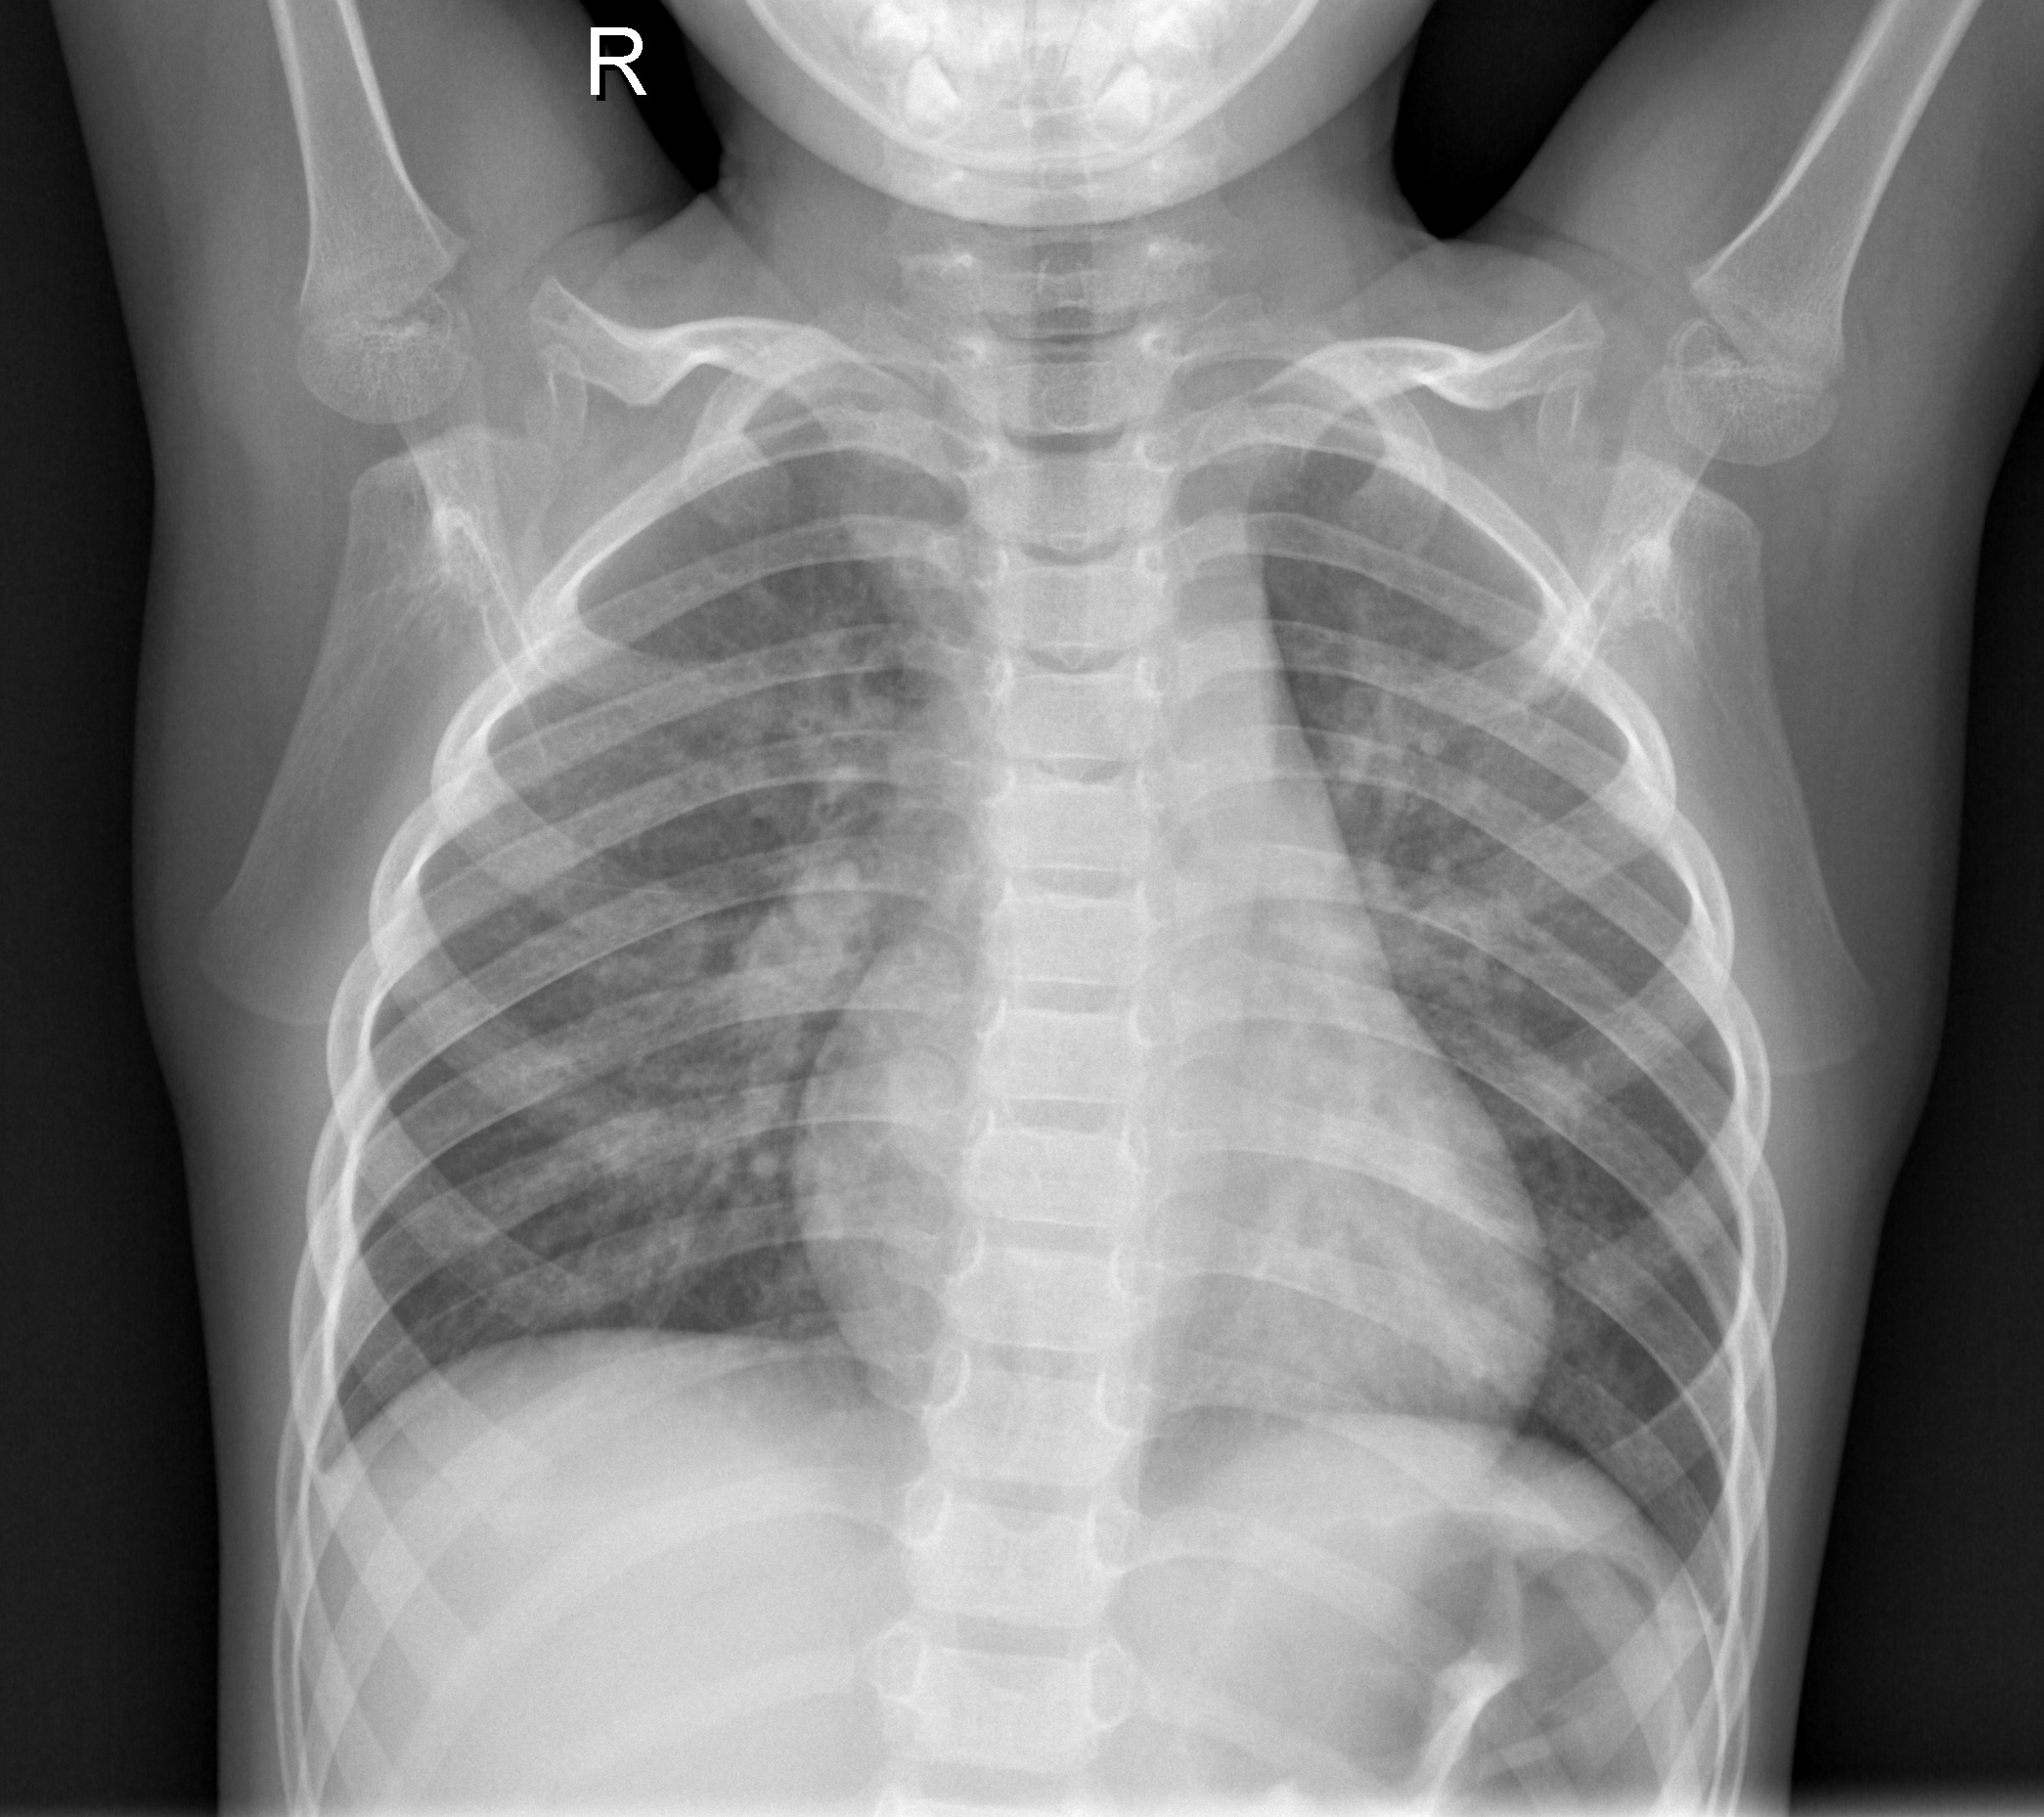

In [5]:
# print out a sample: 
# 0 - Without Covid
wOut_Covid = list(data_path.glob('0/*'))
PIL.Image.open(str(wOut_Covid[0]))

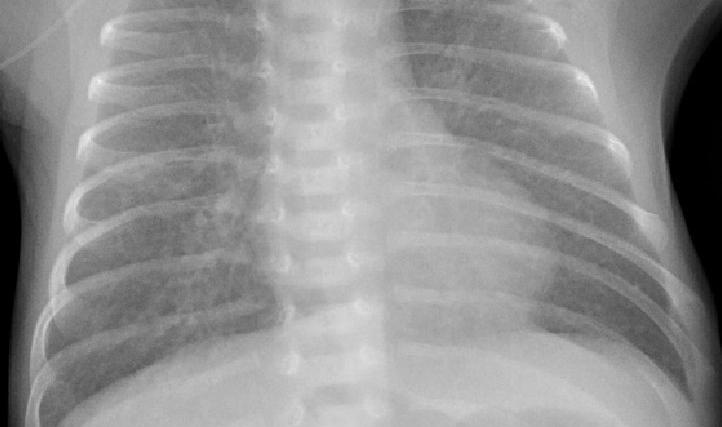

In [6]:
# print out a sample: 
# 1 - With Covid
wOut_Covid = list(data_path.glob('1/*'))
PIL.Image.open(str(wOut_Covid[0]))

### Alright, everything looks pretty good so far, however there are certain images that are larger than others, lets start by specifying the batch size and the image width and height

In [7]:
# specify the batch size nad the image size for the training
batch_size = 32 # smaller bathes gives better results
height = 200
width = 200

In [8]:
# create the data set for training
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=.2,
    subset="training",
    seed=123,
    image_size=(height,width),
    batch_size=batch_size
)

Found 3091 files belonging to 2 classes.
Using 2473 files for training.


In [9]:
# create the data set for validation
validate_dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=.2,
    subset="validation",
    seed=123,
    image_size=(height,width),
    batch_size=batch_size
)

Found 3091 files belonging to 2 classes.
Using 618 files for validation.


Just remember that:   
0 = Without covid  
1 = With Covid  

In [10]:
# finding the class names
class_names = train_dataset.class_names
print(class_names)

['0', '1']


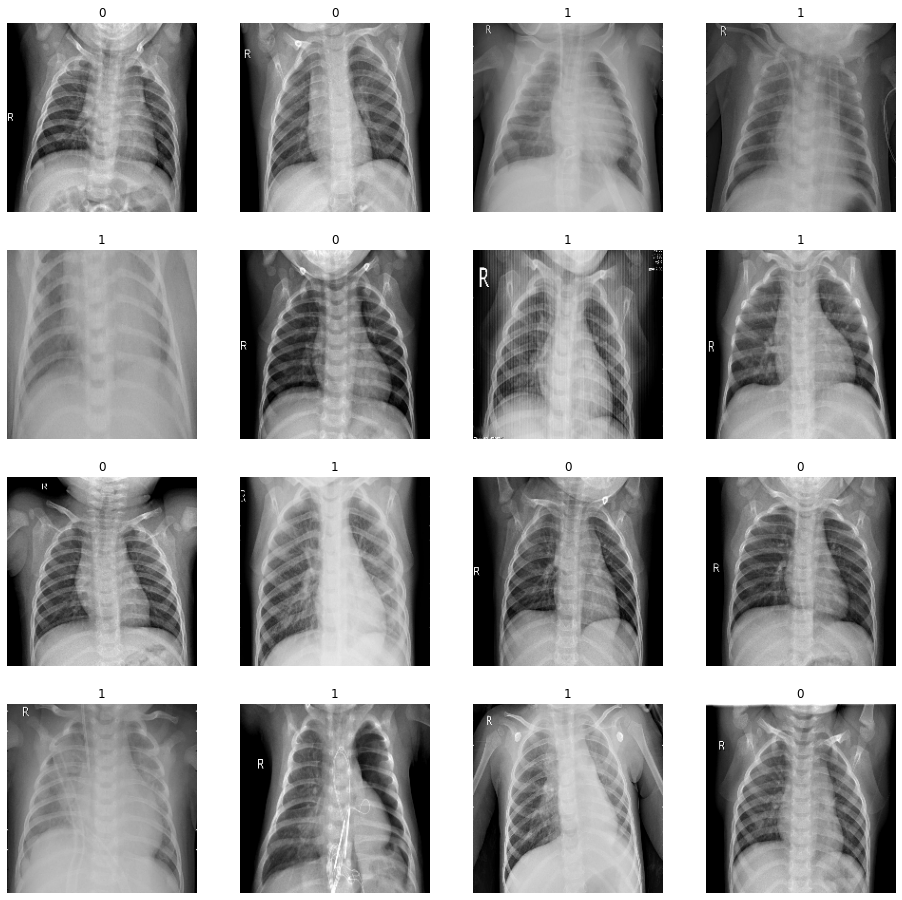

In [11]:
# visualize the data: visual purposes (optional)
# set the size of the fiture
plt.figure(figsize=(16,16))

# loop through the training dataset and pull out some examples
for images, labels in train_dataset.take(1):
    for x in range(16):
        ax = plt.subplot(4, 4, x + 1)
        plt.imshow(images[x].numpy().astype("uint8"))
        plt.title(class_names[labels[x]])
        plt.axis('off')


Great! The images look pretty good! Typically, with color images, you would need to rescale the values since RGB colors range from 0 -> 255. Even though our images looks like it consists of black and white we will rescale and standardize it from 0 -> 1 instead. 

In [12]:
# rescaling
normalized = tf.keras.layers.Rescaling(1./255)

In [13]:
# now, lets normalize the training dataset
normalized_trainDS = train_dataset.map(lambda x, y: (normalized(x),y))
image_group, label_group = next(iter(normalized_trainDS))

In [14]:
# pull an example from the group to see
image = image_group[0]
print(np.min(image),np.max(image))

0.0 1.0


**Great, the images should be scaled from 0 to 1. Now from here, you can ignore the rest and start adding your model continuing this point. I will add a model, courtesy of TensorFlow to compare with our models.** 

This preprocessing coding was written with the guidance of TensorFlow's Load and PreProcess Data Webpage. [Link Here](https://www.tensorflow.org/tutorials/load_data/images)

##### Here, we will configure the dataset for performance and then train a model using Keras Sequential

In [15]:
# configuring the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validate_dataset = validate_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
# create our model
num_classes = 2 # with and without covid

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [17]:
# compile to model build it for accuracy
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [18]:
# now we fit the model and see we get! 
model.fit(
  train_dataset,
  validation_data=validate_dataset,
  epochs=3
)

Epoch 1/3
78/78 [==============================] - 26s 327ms/step - loss: 0.4478 - accuracy: 0.7756 - val_loss: 0.1561 - val_accuracy: 0.9434
Epoch 2/3
78/78 [==============================] - 23s 294ms/step - loss: 0.1591 - accuracy: 0.9434 - val_loss: 0.0948 - val_accuracy: 0.9644
Epoch 3/3
78/78 [==============================] - 38s 494ms/step - loss: 0.1064 - accuracy: 0.9600 - val_loss: 0.0668 - val_accuracy: 0.9709


Since we set the epochs to 3 times, the training time is faster compared to epochs = 10.

##### Here is an example of finding the precision of our model

In [19]:
# create our model
num_classes = 1 # since we only have 0 and 1 -> binary

model2 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

In [20]:
model2.compile(
  optimizer='Adam', 
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=[tf.keras.metrics.Precision()])


In [21]:
model2.fit(
  train_dataset,
  validation_data=validate_dataset,
  epochs=3
)

Epoch 1/3
78/78 [==============================] - 34s 420ms/step - loss: 0.3829 - precision: 0.8355 - val_loss: 0.1683 - val_precision: 0.9938
Epoch 2/3
78/78 [==============================] - 22s 283ms/step - loss: 0.2149 - precision: 0.9284 - val_loss: 0.0941 - val_precision: 0.9669
Epoch 3/3
78/78 [==============================] - 25s 316ms/step - loss: 0.1194 - precision: 0.9648 - val_loss: 0.0669 - val_precision: 0.9832
